In [1]:
import tensorflow as tf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('./rtaUtils')

from rtaUtils import paths, experiment, data_loading

import wandb, os
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
print(visible_devices)
for device in visible_devices:
    assert device.device_type != 'GPU'
    
### Features ##################################################################
numeric_feat = [
    'latitude', 'longitude', 'altitude', 'departureDelay', 'vspeed', 'speed', 
    'day_of_week', 'track', 'wind_dir_degrees', 'wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'clouds', 'hav_distance'
]
categoric_feat = [
    'time_of_day', 'operator', 'aerodromeOfDeparture', 'sky_status'
]
objective = ['RTA']

ts_features = [
    'latitude', 'longitude', 'altitude', 'vspeed', 'speed', 'track', 'hav_distance'
]
nts_features = [
    'departureDelay', 'day_of_week', 'wind_dir_degrees','wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'time_of_day', 'operator', 
    'aerodromeOfDeparture', 'sky_status', 'clouds'
]

feat_dict = dict(
    numeric=numeric_feat,
    categoric=categoric_feat,
    objective=objective,
    ts=ts_features,
    nts=nts_features
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
### Experiment setup ##########################################################
n_units      = 20
lookback     = 64
sampling     = 30

epochs       = 30

act_function = 'tanh'
batch_size   = 128
from_parquet = True

model_config = dict(
    n_units=n_units,
    act_function=act_function,
    batch_size=batch_size,
)

### Model configuration #######################################################
model_type   = 'LSTM_LIMC'
months       = '*' # 20220[12]
airport      = 'LIMC'
glob_text    = f'{months}-{airport}'

## Entrenamiento

In [3]:
experimento = experiment.ExperimentVanilla(
    lookback=lookback,
    sampling=sampling,
    model_config=model_config,
    months=months, 
    airport=airport,
    features=feat_dict,
    model_type=model_type
)
experimento.init_model()
# experimento.load_model()
experimento.model.summary()

C:\Users\Jorge\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jorge\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                3200      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 3,221
Trainable params: 3,221
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = experimento.train(epochs=epochs, from_parquet=from_parquet, add_callbacks = []) 
# add_callbacks = [wandCallback]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/30
446/446 [==============================] - 29s 58ms/step - loss: 0.0206 - mean_squared_error: 0.0014 - val_loss: 0.0106 - val_mean_squared_error: 1.9454e-04
Epoch 2/30
446/446 [==============================] - 26s 59ms/step - loss: 0.0081 - mean_squared_error: 1.2219e-04 - val_loss: 0.0114 - val_mean_squared_error: 2.0758e-04
Epoch 3/30
446/446 [==============================] - 26s 59ms/step - loss: 0.0077 - mean_squared_error: 1.1081e-04 - val_loss: 0.0103 - val_mean_squared_error: 1.8369e-04
Epoch 4/30
446/446 [==============================] - 20s 45ms/step - loss: 0.0074 - mean_squared_error: 1.0628e-04 - val_loss: 0.0106 - val_mean_squared_error: 2.0554e-04
Epoch 5/30
446/446 [==============================] - 25s 57ms/step - loss: 0.0072 - mean_squared_error: 1.0129e-04

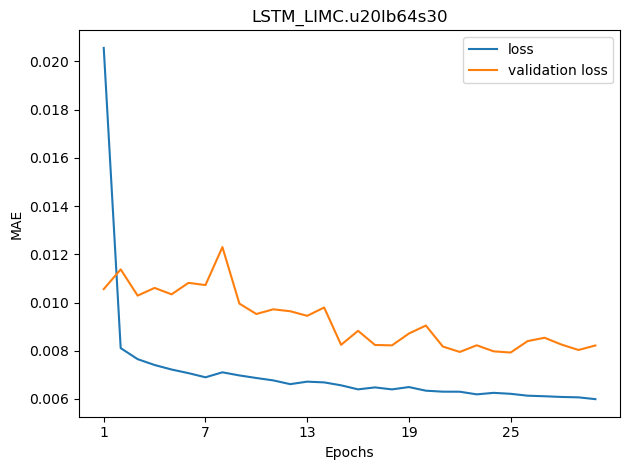

In [5]:
progress = pd.read_csv(experimento.model_path_log)
skip = 0

plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['loss'].iloc[skip:], label='loss')
plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['val_loss'].iloc[skip:], label='validation loss')
plt.title(f'{model_type}.u{n_units}lb{lookback}s{sampling}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
if progress.shape[0]>10:
    plt.xticks([str(x) for x in range(1+skip,progress.shape[0],progress.shape[0]//5)])
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación

In [6]:
experimento.load_model('best')

In [7]:
experimento.evaluate(from_parquet=True, print_err=True)

95/95 [==============================] - 3s 25ms/step
RTA ===================================
Test set          | MAE:        200.675
                  | RMSE:       263.051
                  | Mean:        18.621
                  | MAPE:        36.503
                  | Muestra:     12,113


In [8]:
experimento.evaluate_at_times()

test: Finalizado                                                  


In [9]:
experimento.get_evaluation_results('long').head(50)

,dataset,feature,time,MAE,RMSE,MAPE,Mean,Sample
0,test,RTA,all,200.674622,263.050720,36.503132,18.620859,12113
1,test,RTA,15,154.628571,224.631607,16.663834,-55.419773,79
2,test,RTA,30,168.813812,231.423721,9.296408,-1.550248,86
3,test,RTA,60,221.649719,269.610992,6.131233,51.585197,85


In [ ]:
# Exportar a CSV
experimento.get_evaluation_results('wide')\
           .to_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                 header=True,index=False, encoding='utf8')

## Generación de informe

In [ ]:
from rtaUtils.experiment import report_columns
report_df_long = pd.DataFrame.from_dict(
    experimento.results, orient='index',
    columns=['dataset','time',*report_columns])
report_df = report_df_long.pivot_table(index=['dataset'], columns=['time'], values=report_columns)
report_df.columns = [' '.join((str(y) for y in x)) 
                     for x in report_df.columns.to_flat_index()]
report_df = report_df.reset_index()
# report_df[[x for x in report_df.columns if report_columns[0] in x]]

In [ ]:
report_df

In [ ]:
report_df.to_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                 header=True, encoding='utf8')

In [13]:
# Exportar a CSV
experimento.get_evaluation_results('wide')\
           .to_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                 header=True,index=False, encoding='utf8')

## Visualización

In [1]:
import plotly.express as px

In [5]:
report_df = pd.read_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                        header=0, encoding='utf8')

In [13]:
vis = pd.merge(
    report_df[['MAE all','RMSE all','MAPE all', 'Mean all','Sample all','dataset']],
    pd.read_csv('./data/airports.csv', sep = ','),
    left_on='dataset', right_on='id'
)

In [14]:
td = data_loading.load_final_data(months, 'test')[['aerodromeOfDeparture', 'fpId']].drop_duplicates()\
              .groupby('aerodromeOfDeparture').count()

vis = pd.merge(vis, td, left_on='dataset', right_on='aerodromeOfDeparture')

In [15]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAE all', size='fpId',
#                   range_color=(50,300),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f',
                                'Sample all':':.3f'},
                  hover_name='dataset'
                 )

In [11]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAPE all', size='fpId',
                  # range_color=(0,0.2),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )